In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from scipy import stats

%matplotlib inline

In [2]:
! tree -d ..

..
├── data
│   ├── train
│   │   ├── axial
│   │   ├── coronal
│   │   └── sagittal
│   └── valid
│       ├── axial
│       ├── coronal
│       └── sagittal
└── mrnet-fastai

10 directories


In [3]:
data_path = Path('../data')
train_path = data_path/'train'
valid_path = data_path/'valid'

In [4]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(train_abnl.groupby('Abnormal').count())
train_abnl.head()

          Case
Abnormal      
0          217
1          913


,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [5]:
def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = data_path/plane/'{}.npy'.format(case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

In [6]:
from ipywidgets import interact, Dropdown, IntSlider

class KneePlot():
    def __init__(self, x, figsize=(10, 10)):
        self.x = x
        self.planes = list(x.keys())
        self.slice_nums = {plane: self.x[plane].shape[0] for plane in self.planes}
        self.figsize = figsize
    
    def _plot_slices(self, plane, im_slice): 
        fig, ax = plt.subplots(1, 1, figsize=self.figsize)
        ax.imshow(self.x[plane][im_slice, :, :])
        plt.show()
    
    def draw(self):
        planes_widget = Dropdown(options=self.planes)
        plane_init = self.planes[0]
        slice_init = self.slice_nums[plane_init] - 1
        slices_widget = IntSlider(min=0, max=slice_init, value=slice_init//2)
        def update_slices_widget(*args):
            slices_widget.max = self.slice_nums[planes_widget.value] - 1
            slices_widget.value = slices_widget.max // 2
        planes_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices, plane=planes_widget, im_slice=slices_widget)
    
    def resize(self, figsize):
        self.figsize = figsize
        self.draw()
        

In [7]:
def slice_num(case, plane):
    data = load_one_stack(case, plane=plane)
    return data.shape[0]

train_cases = train_abnl.copy()
planes = ['coronal', 'sagittal', 'axial']
slices = {plane: {} for plane in planes}

for i, case in train_cases.Case.iteritems():
    for plane in planes:
        slices[plane][i] = slice_num(case, plane)

for plane in planes:
    train_cases['{}_slices'.format(plane)] = pd.Series(slices[plane])

train_cases.head()

,Case,Abnormal,coronal_slices,sagittal_slices,axial_slices
0,0000,1,36,36,44
1,0001,1,20,26,30
2,0002,1,32,32,38
3,0003,1,28,30,33
4,0004,1,34,32,40


In [8]:
train_cases.to_pickle('train_cases.pkl')

In [9]:
train_cases = pd.read_pickle('train_cases.pkl')

In [10]:
stats = {plane: {'mean': train_cases['{}_slices'.format(plane)].mean(),
                 'max': int(train_cases['{}_slices'.format(plane)].max())}
         for plane in planes}

with open('slice_stats.json', 'w') as outfile:
    json.dump(stats, outfile, indent=4)


In [ ]:
def midslice_pixels(case, plane='coronal'):
    data = load_one_stack(case, plane=plane)
    mid_slc = data.shape[0] // 2
    return data[mid_slc].ravel()


In [30]:
case = train_abnl.Case[0]
data = midslice_pixels(case, plane)
print(np.median(data))

54.0
[3]


In [45]:
train_pix_distr = train_abnl.copy()
pixel_mean = {plane: {} for plane in planes}
pixel_std = {plane: {} for plane in planes}
pixel_skew = {plane: {} for plane in planes}
pixel_kurtosis = {plane: {} for plane in planes}

for i, case in train_pix_distr.Case.iteritems():
    for plane in planes:
        data = midslice_pixels(case, plane)
        pixel_mean[plane][i] = data.mean()
        pixel_std[plane][i] = data.std()
        pixel_skew[plane][i] = stats.skew(data)
        pixel_kurtosis[plane][i] = stats.kurtosis(data)

for plane in planes:
    train_pix_distr['{}_mean'.format(plane)] = pd.Series(pixel_mean[plane])
    train_pix_distr['{}_std'.format(plane)] = pd.Series(pixel_std[plane])
    train_pix_distr['{}_skew'.format(plane)] = pd.Series(pixel_skew[plane])
    train_pix_distr['{}_kurtosis'.format(plane)] = pd.Series(pixel_kurtosis[plane])

train_pix_distr.head()

,Case,Abnormal,coronal_mean,coronal_std,coronal_skew,coronal_kurtosis,sagittal_mean,sagittal_std,sagittal_skew,sagittal_kurtosis,axial_mean,axial_std,axial_skew,axial_kurtosis
0,0000,1,71.320831,68.671506,0.788693,-0.379464,61.738129,46.342750,1.628218,3.243144,59.856781,59.094418,1.211688,0.649745
1,0001,1,58.790421,66.833145,1.074413,0.113197,48.656082,44.929455,2.170335,5.599548,59.896683,63.814414,1.066763,0.206605
2,0002,1,56.239349,66.842706,1.156311,0.268376,65.692810,50.465059,1.328415,1.876179,54.045578,59.760746,1.407676,1.066305
3,0003,1,73.796158,63.836458,0.874590,-0.011280,72.277161,39.581132,2.194461,6.469140,70.078461,62.892070,0.870823,-0.090903
4,0004,1,68.889694,69.390991,0.795844,-0.441022,67.808701,48.656739,1.478256,2.703988,64.260574,63.752736,0.997497,0.066971


In [46]:
train_pix_distr.to_pickle('train_pix_distr.pkl')

In [47]:
train_pix_distr = pd.read_pickle('train_pix_distr.pkl')

In [48]:
train_pix_distr.describe()

,Abnormal,coronal_mean,coronal_std,coronal_skew,coronal_kurtosis,sagittal_mean,sagittal_std,sagittal_skew,sagittal_kurtosis,axial_mean,axial_std,axial_skew,axial_kurtosis
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,0.807965,67.108620,66.807553,0.924133,-0.102812,60.945985,47.504459,1.614026,3.252651,62.160557,60.441420,1.150326,0.604885
std,0.394075,7.461650,1.932889,0.158396,0.310322,5.704947,2.400126,0.246937,1.036443,6.111930,2.642779,0.213733,0.605289
min,0.000000,33.908539,57.499752,0.509969,-0.720145,44.160080,39.581132,1.040601,1.076109,44.025360,47.182842,0.570228,-0.645455
25%,1.000000,61.817505,65.923906,0.809943,-0.320805,56.401314,45.860865,1.435304,2.498895,57.822517,58.662771,1.001069,0.169961
50%,1.000000,66.851761,67.110119,0.910379,-0.149972,61.646736,47.482166,1.582371,3.042690,62.237869,60.733060,1.131926,0.481673
75%,1.000000,72.427654,68.049955,1.023350,0.063486,65.686928,49.298908,1.763213,3.817128,66.127842,62.296075,1.287480,0.947084
max,1.000000,93.560928,71.364893,2.027571,3.209139,77.889709,54.762619,2.354472,7.170039,82.017792,67.932261,2.155746,4.700193


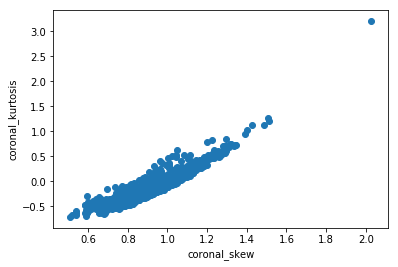

In [49]:
plt.scatter(train_pix_distr.coronal_skew, train_pix_distr.coronal_kurtosis)
plt.xlabel('coronal_skew')
plt.ylabel('coronal_kurtosis')
plt.show()

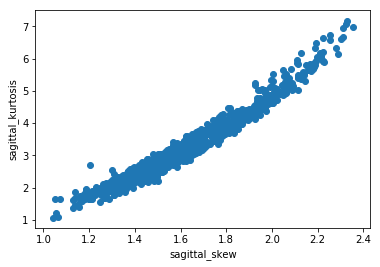

(2.1944611566637406, 6.469139918885254)

In [50]:
plt.scatter(train_pix_distr.sagittal_skew, train_pix_distr.sagittal_kurtosis)
plt.xlabel('sagittal_skew')
plt.ylabel('sagittal_kurtosis')
plt.show()

(train_pix_distr.sagittal_skew[3], train_pix_distr.sagittal_kurtosis[3])

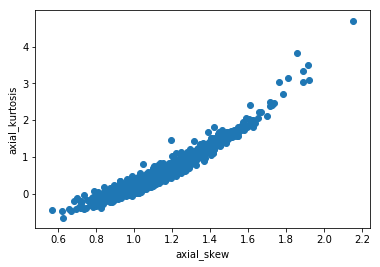

In [51]:
plt.scatter(train_pix_distr.axial_skew, train_pix_distr.axial_kurtosis)
plt.xlabel('axial_skew')
plt.ylabel('axial_kurtosis')
plt.show()

In [21]:
plt.style.use('default')
%matplotlib inline

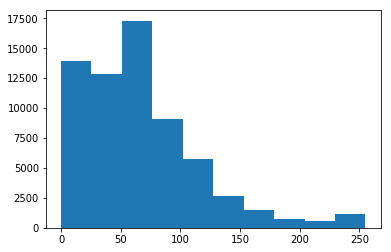

In [42]:
# n = 0
n += 1
case = train_abnl.Case[n]
data = midslice_pixels(case, plane='sagittal')
plt.hist(data);

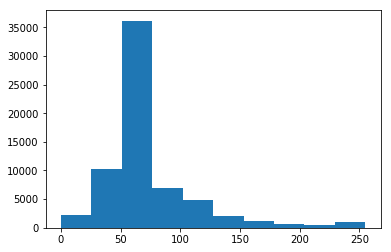

In [43]:
case2 = train_abnl.Case[3]
data2 = midslice_pixels(case2, plane='sagittal')
plt.hist(data2);

In [44]:
print(stats.skew(data), stats.skew(data2))
print(stats.kurtosis(data), stats.kurtosis(data2))

1.4782559208674464 2.1944611566637406
2.7039878741007444 6.469139918885254


In [52]:
def cdf(arr):
    n = len(arr)
    x = np.sort(arr)
    y = np.array(range(n)) / float(n)
    return [x, y]

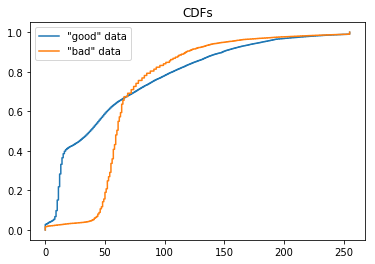

In [54]:
fig, ax = plt.subplots(1, 1)
x, y = cdf(data)
ax.plot(x, y, label='"good" data')
x2, y2 = cdf(data2)
ax.plot(x2, y2, label='"bad" data')
ax.legend()
ax.set_title('CDFs')
plt.show()

In [74]:
def limit_range(mean, std, mult=2): return (mean - mult * std, mean + mult * std)

def col_stats(df, col): return df[col].mean(), df[col].std()

def isolate_outliers(df, plane, mults=(2,2), logic='and'):
    col_s = '{}_skew'.format(plane)
    col_k = '{}_kurtosis'.format(plane)
    s_l = limit_range(*col_stats(df, col_s), mult=mults[0])
    k_l = limit_range(*col_stats(df, col_k), mult=mults[1])
    filt1 = df[col_s] > s_l[1]
    filt2 = df[col_k] > k_l[1]
    if logic == 'and': return df[filt1 & filt2].copy()
    else: return df[filt1 | filt2].copy()


In [75]:
cor_outliers = isolate_outliers(train_pix_distr, 'coronal', mults=(3,3)).reset_index(drop=True)
cor_outliers

,Case,Abnormal,coronal_mean,coronal_std,coronal_skew,coronal_kurtosis,sagittal_mean,sagittal_std,sagittal_skew,sagittal_kurtosis,axial_mean,axial_std,axial_skew,axial_kurtosis
0,0120,0,44.252090,64.112238,1.514377,1.208507,51.703293,48.358664,1.829179,4.040540,57.324478,56.572870,1.404877,1.512652
1,0495,0,44.061386,65.022344,1.488246,1.119383,54.151077,50.763513,1.528136,2.513731,59.852539,58.078193,1.303142,1.030734
2,0704,1,46.473938,63.169366,1.507740,1.265137,51.582199,51.561800,1.609749,2.820521,61.635010,57.990829,1.254581,0.945078
3,0800,1,48.361313,62.902976,1.428040,1.124678,49.673035,45.496367,2.113568,5.024562,44.025360,53.925300,1.923981,3.081927
4,1082,0,33.908539,57.817496,2.027571,3.209139,53.181183,52.031345,1.462177,2.257622,56.440659,61.170271,1.237094,0.736230


In [70]:
plt.style.use('grayscale')
%matplotlib inline

In [77]:
# n = 0
n += 1
print(n)
case = cor_outliers.Case[n]
print(case)
x = load_stacks(case)
plot = KneePlot(x, figsize=(8, 8))
plot.draw()

4
1082


interactive(children=(Dropdown(description='plane', options=('coronal', 'sagittal', 'axial'), value='coronal')…

In [78]:
sag_outliers = isolate_outliers(train_pix_distr, 'sagittal', mults=(2,3)).reset_index(drop=True)
sag_outliers

,Case,Abnormal,coronal_mean,coronal_std,coronal_skew,coronal_kurtosis,sagittal_mean,sagittal_std,sagittal_skew,sagittal_kurtosis,axial_mean,axial_std,axial_skew,axial_kurtosis
0,0003,1,73.796158,63.836458,0.874590,-0.011280,72.277161,39.581132,2.194461,6.469140,70.078461,62.892070,0.870823,-0.090903
1,0198,1,63.290848,66.058350,1.037300,0.097245,54.766632,40.988216,2.324174,7.085828,65.788467,63.745633,0.933996,-0.025002
2,0599,0,58.734436,64.354778,1.164021,0.421329,48.307556,41.856615,2.309733,6.660375,63.795197,58.098930,1.209188,0.876748
3,0692,1,56.274277,65.385217,1.218450,0.533243,58.568542,40.700407,2.354472,6.968791,67.049896,58.810423,1.163043,0.648329
4,0711,0,60.549057,63.172168,1.205468,0.527127,58.201218,41.896720,2.255032,6.714704,66.145050,65.405677,0.872736,-0.174139
5,0767,1,52.014465,64.511241,1.296076,0.707293,56.175491,40.487757,2.327628,7.170039,63.208603,57.870282,1.211769,0.972336
6,0789,1,70.405350,67.873645,0.828188,-0.301159,54.660980,41.786984,2.252001,6.578970,71.911301,60.501355,0.912518,0.185487
7,0901,1,55.158005,65.793740,1.208813,0.454154,55.913940,41.521643,2.221861,6.633888,57.279465,57.237231,1.349385,1.345829
8,0949,1,69.758530,67.194522,0.847054,-0.272130,55.778183,42.242003,2.309987,6.931893,63.297775,60.312212,1.103731,0.471564
9,0977,1,72.593536,64.977253,0.856578,-0.125540,50.080231,43.221393,2.302879,6.619957,63.683136,58.348080,1.259950,0.982429


In [85]:
# n = 0
n += 1
print(n)
case = sag_outliers.Case[n]
print(case)
x = load_stacks(case)
plot = KneePlot(x, figsize=(8, 8))
plot.draw()

6
0789


interactive(children=(Dropdown(description='plane', options=('coronal', 'sagittal', 'axial'), value='coronal')…

In [69]:
ax_outliers = isolate_outliers(train_pix_distr, 'axial', mults=(3,3)).reset_index(drop=True)
ax_outliers

,Case,Abnormal,coronal_mean,coronal_std,coronal_skew,coronal_kurtosis,sagittal_mean,sagittal_std,sagittal_skew,sagittal_kurtosis,axial_mean,axial_std,axial_skew,axial_kurtosis
0,0142,1,73.240021,66.016397,0.827725,-0.296361,55.574951,46.585017,1.914302,4.183031,53.707840,50.065185,1.915114,3.497323
1,0143,0,56.109558,65.731737,1.182377,0.428905,59.092209,43.140789,2.057419,5.279754,54.006424,48.735659,1.860164,3.812772
2,0164,1,66.624573,66.451795,0.976381,-0.058222,62.879532,41.598072,2.139051,5.556798,55.728622,49.969718,1.889314,3.337236
3,0371,1,70.660873,66.578103,0.906362,-0.155981,63.836090,42.728925,2.114791,5.476267,60.082932,48.564276,1.812445,3.154111
4,0477,0,57.667618,68.078148,1.093988,0.130958,49.591248,45.584699,2.092626,5.067410,52.761307,47.182842,2.155746,4.700193
5,0625,0,58.539291,64.965031,1.161014,0.374259,51.937363,45.553812,1.968538,4.543074,46.149933,53.842773,1.892603,3.032377
6,0800,1,48.361313,62.902976,1.428040,1.124678,49.673035,45.496367,2.113568,5.024562,44.025360,53.925300,1.923981,3.081927


In [ ]:
n = 0
# n += 1
print(n)
case = ax_outliers.Case[n]
print(case)
x = load_stacks(case)
plot = KneePlot(x, figsize=(8, 8))
plot.draw()